# Age Classification

In [1]:
import re
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import pandas as pd 

##  Preprocessing

In [2]:
df = pd.read_csv('blogtext.csv')

In [3]:
df.head()

,id,gender,age,topic,sign,date,text
0,2059027,male,15,Student,Leo,"14,May,2004","Info has been found (+/- 100 pages,..."
1,2059027,male,15,Student,Leo,"13,May,2004",These are the team members: Drewe...
2,2059027,male,15,Student,Leo,"12,May,2004",In het kader van kernfusie op aarde...
3,2059027,male,15,Student,Leo,"12,May,2004",testing!!! testing!!!
4,3581210,male,33,InvestmentBanking,Aquarius,"11,June,2004",Thanks to Yahoo!'s Toolbar I can ...


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 681284 entries, 0 to 681283
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      681284 non-null  int64 
 1   gender  681284 non-null  object
 2   age     681284 non-null  int64 
 3   topic   681284 non-null  object
 4   sign    681284 non-null  object
 5   date    681284 non-null  object
 6   text    681284 non-null  object
dtypes: int64(2), object(5)
memory usage: 36.4+ MB


delete unnecessary columns

In [5]:
df.drop(['id','date', 'sign', 'topic'], axis=1, inplace=True)

**Some stats about gender:**

In [6]:
df['gender'].describe()

count     681284
unique         2
top         male
freq      345193
Name: gender, dtype: object

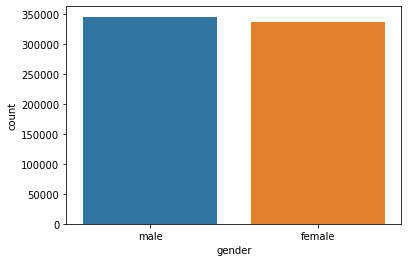

In [7]:
sns.countplot(x="gender", data=df)

**Age:**

In [8]:
df['age'].describe()

count    681284.000000
mean         23.932326
std           7.786009
min          13.000000
25%          17.000000
50%          24.000000
75%          26.000000
max          48.000000
Name: age, dtype: float64

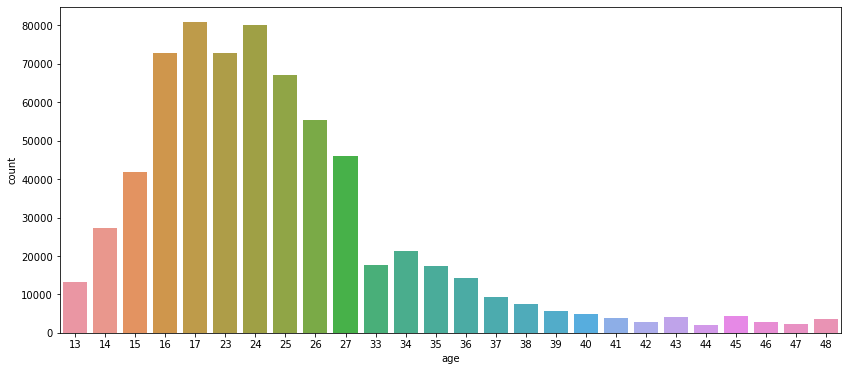

In [9]:
plt.figure(figsize = (14,6))
sns.countplot(x="age", data=df)

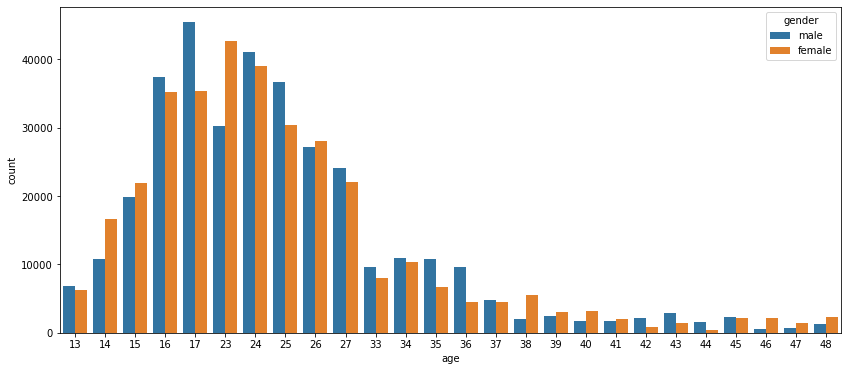

In [10]:
plt.figure(figsize = (14,6))
sns.countplot(x="age", hue="gender", data=df, )

**let's see how long text of blog posts are**

In [11]:
df['number of words'] = df['text'].apply( lambda text: len(text.split()))

In [12]:
df['number of words'].describe()

count    681284.000000
mean        200.786742
std         415.160622
min           0.000000
25%          37.000000
50%         112.000000
75%         255.000000
max      131169.000000
Name: number of words, dtype: float64

In [13]:
empty_text = len(df[df['number of words'] == 0])
print(f'number of empty texts: { empty_text }')

number of empty texts: 3119


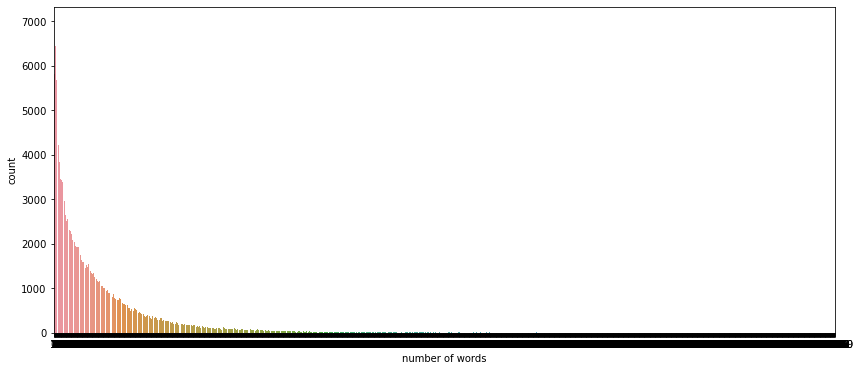

In [14]:
plt.figure(figsize = (14,6))
sns.countplot(x="number of words", data=df)

Split data on train and test

In [15]:
texts, target = df['text'], df['age']

In [16]:
from sklearn.model_selection import train_test_split
texts_train, texts_test, y_train, y_test = train_test_split(texts, target, test_size=0.2, random_state=42)

transform age to age group according to the task

In [17]:
def age_group(age):
    if age < 20:
        return 0
    elif age < 30:
        return 1
    return 2  

In [18]:
y_train_group = [age_group(y) for y in y_train]
y_test_group = [age_group(y) for y in y_test]

(array([188646.,      0.,      0.,      0.,      0., 257003.,      0.,
             0.,      0.,  99378.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

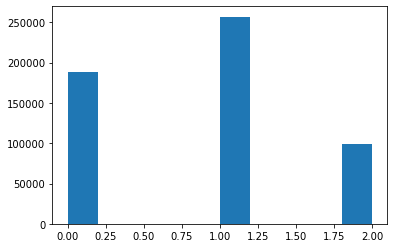

In [19]:
plt.hist(y_train_group)

(array([47221.,     0.,     0.,     0.,     0., 64444.,     0.,     0.,
            0., 24592.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

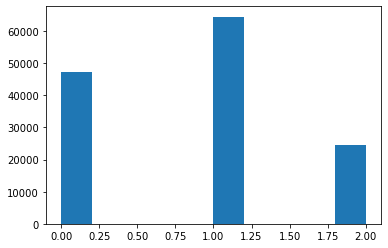

In [20]:
plt.hist(y_test_group)

## Naive Bayes

The are two steps in classical methods for text classification. Firstly, we should define how to extract features from text. And secondly we should choose classification model. So, let's try to use different approaches for feature extractor. 

As a basis we will use Naive Bayes model. 

Let's start with simple bag of words. First thing that quite interesting how considering stop words  impact on the outcomes

In [21]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

vectorizer = CountVectorizer() # TODO
X_train_bow = vectorizer.fit_transform(texts_train)
X_test_bow = vectorizer.transform(texts_test)

vectorizer2 = CountVectorizer(min_df = 2, max_df=0.85) # TODO
X_train_bow2 = vectorizer2.fit_transform(texts_train)
X_test_bow2 = vectorizer2.transform(texts_test)

vectorizer3 = CountVectorizer(min_df = 5, max_df=0.75) # TODO
X_train_bow3 = vectorizer3.fit_transform(texts_train)
X_test_bow3 = vectorizer3.transform(texts_test)


In [22]:
vectorizer.get_feature_names()[1::100000]

['000',
 'callling',
 'firelight',
 'kompeted',
 'pantywaists',
 'spectraview',
 'zadnje']

In [23]:
print(f'original shape: {X_train_bow.shape}')
print(f'without some stop words: {X_train_bow2.shape}')
print(f'without more stop words: {X_train_bow3.shape}')

original shape: (545027, 632315)
without some stop words: (545027, 259652)
without more stop words: (545027, 126244)


Time to fit naive bayes

In [24]:
from sklearn.naive_bayes import MultinomialNB

naive_model_bow =  MultinomialNB(alpha = 1.0)
naive_model_bow.fit(X_train_bow, y_train_group)

naive_model_bow2 =  MultinomialNB(alpha = 1.0)
naive_model_bow2.fit(X_train_bow2, y_train_group)

naive_model_bow3 =  MultinomialNB(alpha = 1.0)
naive_model_bow3.fit(X_train_bow3, y_train_group)

MultinomialNB()

In [25]:
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, precision_score, recall_score
from sklearn.metrics import plot_confusion_matrix

def apply_model(name, X, y, model, print_stats = True):
    plot_confusion_matrix(model, X, y, labels = [0,1,2]) 
    y_pred = model.predict(X)
    print(f'{name} results:')
    print(f"Model accuracy: {accuracy_score(y, model.predict(X)):.3f}")

train results:
Model accuracy: 0.677


No handles with labels found to put in legend.


test results:
Model accuracy: 0.645


<Figure size 720x576 with 0 Axes>

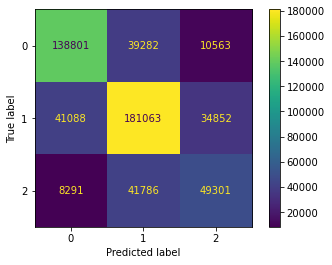

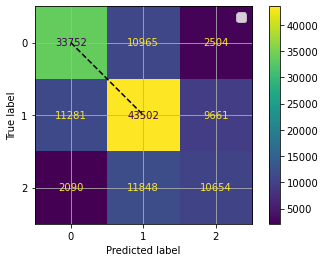

In [26]:

plt.figure(figsize = (10,8))
apply_model('train', X_train_bow, y_train_group, naive_model_bow),
apply_model('test', X_test_bow, y_test_group, naive_model_bow, print_stats = True)

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.grid()

How much stop words affect on results:

test with all words results:
Model accuracy: 0.645
test without stop words results:
Model accuracy: 0.638


No handles with labels found to put in legend.


test without more stop words results:
Model accuracy: 0.633


<Figure size 720x576 with 0 Axes>

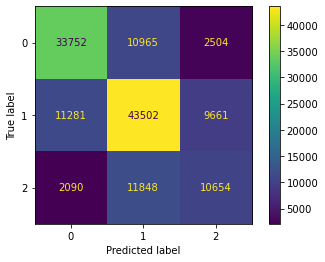

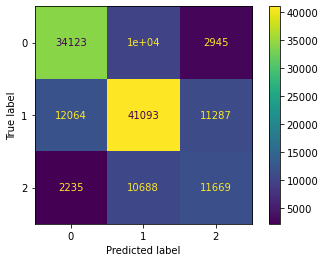

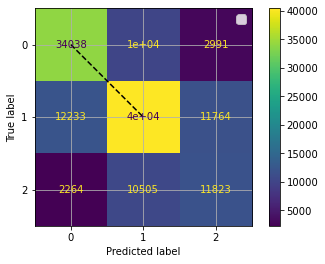

In [27]:
plt.figure(figsize = (10,8))
apply_model('test with all words', X_test_bow, y_test_group, naive_model_bow, print_stats = True),
apply_model('test without stop words', X_test_bow2, y_test_group, naive_model_bow2, print_stats = True),
apply_model('test without more stop words', X_test_bow3, y_test_group, naive_model_bow3, print_stats = True)

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.grid()

**Conclusion:**

After Removing some stop words quality goes down only around $0.5\% $ but at the same time we saves more than half the space. 

By default we will use second approach

Next, let's try to use tf-idf features.

In [28]:
vectorizer_tf_idf = TfidfVectorizer(min_df = 2, max_df=0.85)
X_train_tf_idf = vectorizer_tf_idf.fit_transform(texts_train)
X_test_tf_idf = vectorizer_tf_idf.transform(texts_test)

In [29]:
naive_model_tf_idf =  MultinomialNB(alpha = 1.0)
naive_model_tf_idf.fit(X_train_tf_idf, y_train_group)

MultinomialNB()

train tf-idf features results:
Model accuracy: 0.669
test tf-idf features results:
Model accuracy: 0.651


No handles with labels found to put in legend.


test bag_of_words features results:
Model accuracy: 0.638


<Figure size 720x576 with 0 Axes>

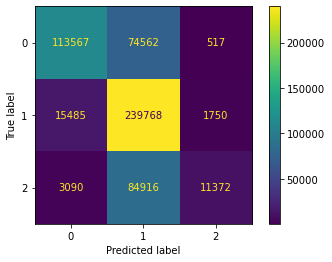

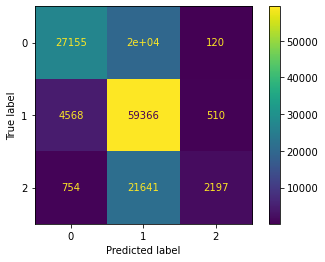

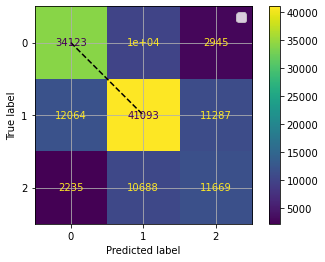

In [30]:
plt.figure(figsize = (10,8))
apply_model('train tf-idf features', X_train_tf_idf, y_train_group, naive_model_tf_idf)
apply_model('test tf-idf features', X_test_tf_idf, y_test_group, naive_model_tf_idf, print_stats = True)
apply_model('test bag_of_words features', X_test_bow2, y_test_group, naive_model_bow2, print_stats = True)

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.grid()

**Conclusion:**

Tf-idf features improve accuracy score more than $1\%$. That's great!

Shape for sure the same as relevant BOW model

In [31]:
print(f' shape of tf-idf fearures: {X_train_tf_idf.shape}')

 shape of tf-idf fearures: (545027, 259652)


Another idea is to use bigrams as features.

It may help model to better "understand" meaning of the text. But at the same time this will require extra space.

In [32]:
vectorizer_bigram = CountVectorizer(min_df = 2, max_df=0.85, ngram_range = (2,2))
X_train_bigram = vectorizer_bigram.fit_transform(texts_train)
X_test_bigram = vectorizer_bigram.transform(texts_test)

vectorizer_ngram = CountVectorizer(min_df = 2, max_df=0.85, ngram_range = (1,2))
X_train_ngram = vectorizer_ngram.fit_transform(texts_train)
X_test_ngram = vectorizer_ngram.transform(texts_test)

In [33]:
naive_model_bigram =  MultinomialNB(alpha = 1.0)
naive_model_bigram.fit(X_train_bigram, y_train_group)

naive_model_ngram =  MultinomialNB(alpha = 1.0)
naive_model_ngram.fit(X_train_ngram, y_train_group)

MultinomialNB()

test simple bow results:
Model accuracy: 0.638
test bigram results:
Model accuracy: 0.678
test words + bigrams results:


No handles with labels found to put in legend.


Model accuracy: 0.675


<Figure size 720x576 with 0 Axes>

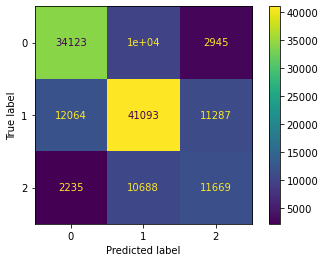

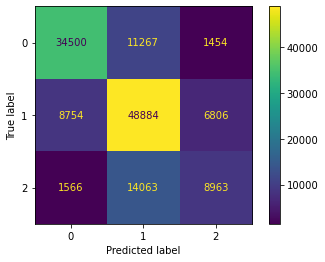

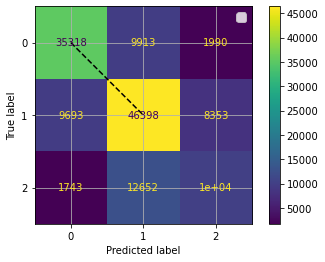

In [34]:
plt.figure(figsize = (10,8))
apply_model('test simple bow', X_test_bow2, y_test_group, naive_model_bow2, print_stats = True),
apply_model('test bigram', X_test_bigram, y_test_group, naive_model_bigram, print_stats = True),
apply_model('test words + bigrams', X_test_ngram, y_test_group, naive_model_ngram, print_stats = True)

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.grid()

In [35]:
print(f'original shape: {X_train_bow2.shape}')
print(f' bigrams shape: {X_train_bigram.shape}')
print(f'words + bigrams shape: {X_train_ngram.shape}')
print(f'difference: {X_train_ngram.shape[1] / X_train_bow2.shape[1]}')

original shape: (545027, 259652)
 bigrams shape: (545027, 4264658)
words + bigrams shape: (545027, 4524310)
difference: 17.42451434997612


So, we improve quality quite a lot (above $4\%$), but at the same time memory usage increased more than 17 times!

One more thing we can try is to look how we define word in our model. 

For instance our model do not consider exclamation mark as word. 

In [36]:
'!' in vectorizer.get_feature_names()

False

So, we may want to consider some symbols as a word. Let's see if this helps.

In [37]:
from nltk.tokenize import TweetTokenizer
tokenizer = TweetTokenizer()
def split_text(text):
    return tokenizer.tokenize(text.lower())

In [38]:
split_text("I love you! Really?")

['i', 'love', 'you', '!', 'really', '?']

In [39]:
vectorizer_tokenizer = CountVectorizer(min_df = 2, max_df=0.85, tokenizer=split_text) # TODO
X_train_tokenizer = vectorizer_tokenizer.fit_transform(texts_train)
X_test_tokenizer = vectorizer_tokenizer.transform(texts_test)

In [40]:
naive_model_tokenizer =  MultinomialNB(alpha = 1.0)
naive_model_tokenizer.fit(X_train_tokenizer, y_train_group)

MultinomialNB()

train with tokenizer results:
Model accuracy: 0.651
test with tokenizer results:
Model accuracy: 0.625
test simple bow  results:


No handles with labels found to put in legend.


Model accuracy: 0.638


<Figure size 720x576 with 0 Axes>

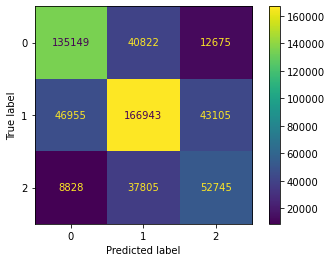

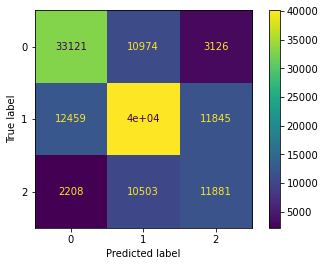

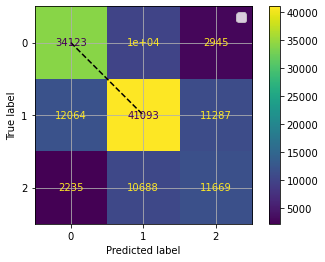

In [41]:
plt.figure(figsize = (10,8))
apply_model('train with tokenizer', X_train_tokenizer, y_train_group, naive_model_tokenizer, print_stats = True),
apply_model('test with tokenizer', X_test_tokenizer, y_test_group, naive_model_tokenizer, print_stats = True),
apply_model('test simple bow ', X_test_bow2, y_test_group, naive_model_bow2, print_stats = True),


plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.grid()

In [42]:
print(f'original shape: {X_train_bow2.shape}')
print(f'shape with TweetTokenizer : {X_train_tokenizer.shape}')

original shape: (545027, 259652)
shape with TweetTokenizer : (545027, 318312)


Finally that doesn't help us. But at least we try)

Also we may try to change our preprosessing. For instance distinguish  capital letters and lowercase letters. Or use stemming in order to decrease vocab size.  

In [43]:
from nltk.stem import PorterStemmer

# init stemmer
porter_stemmer=PorterStemmer()

def preprocessing(text):
    text=text.lower() 
    text=re.sub("\\W"," ",text) # remove special chars
    
    # stem words
    words=re.split("\\s+",text)
    stemmed_words=[porter_stemmer.stem(word=word) for word in words]
    return ' '.join(stemmed_words)

In [44]:
#vectorizer_stemming = CountVectorizer(min_df = 2, max_df=0.85, preprocessor=preprocessing) # TODO
#X_train_stemming = vectorizer_stemming.fit_transform(texts_train)
#X_test_stemming = vectorizer_stemming.transform(texts_test)

So, we have got two good ideas for improving score. 

1) Use tf-idf features 

2) Use bigrams

But can we use both ideas together?

In [45]:
vectorizer_final =  TfidfVectorizer(min_df = 2, max_df=0.85, ngram_range = (1,2))
X_train_final = vectorizer_final.fit_transform(texts_train)
X_test_final = vectorizer_final.transform(texts_test)

In [46]:
naive_model_final = MultinomialNB(alpha = 1.0)
naive_model_final.fit(X_train_final, y_train_group)

MultinomialNB()

simple bow results:
Model accuracy: 0.638
 tf-idf features results:
Model accuracy: 0.651
words + bigrams results:
Model accuracy: 0.675
tf-idf with bigrams results:


No handles with labels found to put in legend.


Model accuracy: 0.604


<Figure size 720x576 with 0 Axes>

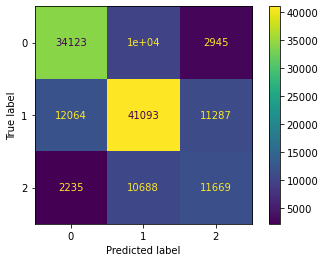

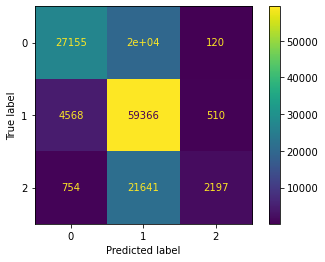

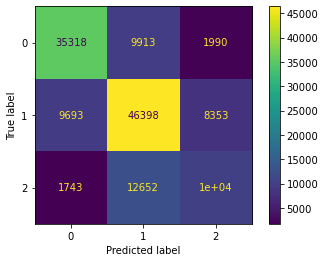

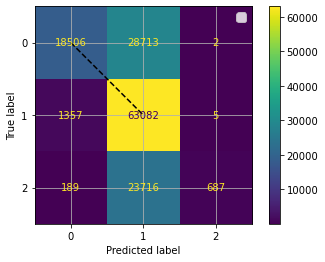

In [47]:
plt.figure(figsize = (10,8))
apply_model('simple bow', X_test_bow2, y_test_group, naive_model_bow2, print_stats = True),
apply_model(' tf-idf features', X_test_tf_idf, y_test_group, naive_model_tf_idf, print_stats = True),
apply_model('words + bigrams', X_test_ngram, y_test_group, naive_model_ngram, print_stats = True),
apply_model('tf-idf with bigrams', X_test_final, y_test_group, naive_model_final, print_stats = True)

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.grid()

**Conclusion**

As we may see using two good ideas together is not always good. 

Finally we have achieved best results using BOW  features for bigrams. But in this case we use too much space. 

## Logistic Regression

So, let's try to use another model.  Logistic Regression, it is your turn!

Firstly we will use LR with simpe BOW features.

In [48]:
from sklearn.linear_model import LogisticRegression
lr_model_bow = LogisticRegression(C = 0.1, max_iter = 1e4).fit(X_train_bow, y_train_group)

train results:
Model accuracy: 0.785


No handles with labels found to put in legend.


test  results:
Model accuracy: 0.705


<Figure size 720x576 with 0 Axes>

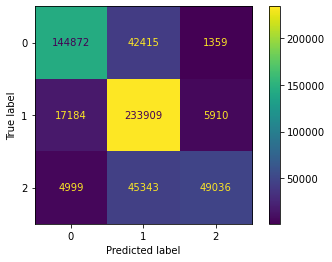

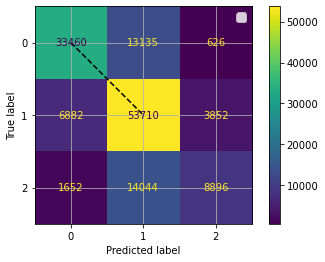

In [49]:
plt.figure(figsize = (10,8))
apply_model('train', X_train_bow, y_train_group, lr_model_bow),
apply_model('test ', X_test_bow, y_test_group, lr_model_bow, print_stats = True)

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.grid()

But what about tf-idf features. As we have seen, it works well in previous case. 

In [50]:
lr_model_tf_idf = LogisticRegression(C = 0.1, max_iter = 1e4).fit(X_train_tf_idf, y_train_group)
#lr_model_ngram = LogisticRegression(C = 0.1, max_iter = 1e4).fit(X_train_ngram, y_train_group) # !!!!

test bow fetures results:
Model accuracy: 0.705


No handles with labels found to put in legend.


tf-idf features results:
Model accuracy: 0.677


<Figure size 720x576 with 0 Axes>

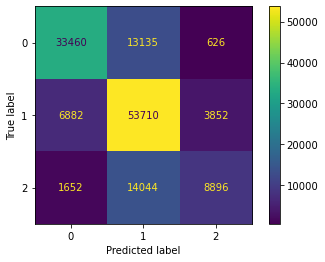

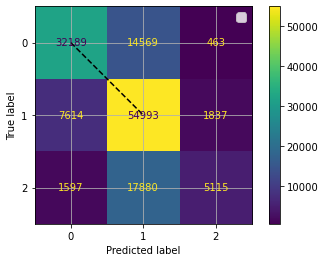

In [51]:
plt.figure(figsize = (10,8))
apply_model('test bow fetures', X_test_bow, y_test_group, lr_model_bow, print_stats = True)
apply_model('tf-idf features', X_test_tf_idf, y_test_group, lr_model_tf_idf, print_stats = True),
#apply_model('words + bigrams', X_test_ngram, y_test_group, lr_model_ngram, print_stats = True) # !!!!

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.grid()

Hm, here it doesn't work well. It's kind of weird. 

### Analysis

where do we make errors?

In [52]:
#word_counts = [sum(x.toarray()) for x in X_test_bow] don't work
word_counts = [min(len(text.split()), 5000) for text in texts_test]
y_pred = lr_model_bow.predict(X_test_bow)
errors = [ prediction != y for prediction, y in zip(y_pred, y_test_group)]

In [53]:
def eval_error(word_counts, errors, predicate):
    error_slice = [error  for cnt,error in zip(word_counts, errors) if predicate(cnt)]
    return sum(error_slice) / len(error_slice)

In [54]:
print(f"error with text less than 37 words {eval_error(word_counts, errors, lambda cnt: cnt < 37)}")
print(f"error with text between  37 and 112 words {eval_error(word_counts, errors, lambda cnt: 37 <= cnt <= 112)}")
print(f"error with text  between  112 and 255 words {eval_error(word_counts, errors, lambda cnt: 112<cnt<= 255)}")
print(f"error with text  greater than 255 words {eval_error(word_counts, errors, lambda cnt:  255 < cnt)}")

error with text less than 37 words 0.40843734250392816
error with text between  37 and 112 words 0.3013662942164071
error with text  between  112 and 255 words 0.24953134153485648
error with text  greater than 255 words 0.22115839243498817


Predictably, our model makes more mistakes when texts are short. What can we do with that?

## Word Vector

But what would be if we define texts features as average of  words embedding.

For simplicity we will use  pre-trained word vectors. 

In [55]:
import gensim.downloader 
embeddings = gensim.downloader.load("fasttext-wiki-news-subwords-300")

In [72]:
from nltk.tokenize import TweetTokenizer
tokenizer = TweetTokenizer()
preprocess = lambda text: ' '.join(tokenizer.tokenize(text.lower()))

In [73]:
def vectorize_sum(text):
    """
    implement a function that converts preprocessed text to a sum of token vectors
    """
    embedding_dim = embeddings.wv.vectors.shape[1]
    features =  np.zeros([embedding_dim], dtype='float64')
    features += np.mean([embeddings.get_vector(token) for token in text.split() if token in embeddings], axis = 0)
    if features is not None: 
        return features
    return np.zeros([embedding_dim], dtype='float64')

Here we try to use this approach for all texts. Probably it's not the best idea.

In [74]:
X_train_wv = np.stack([vectorize_sum(preprocess(text)) for text in texts_train])
X_test_wv = np.stack([vectorize_sum(preprocess(text)) for text in texts_test])

/Applications/anaconda3/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """


In [75]:
X_train_wv = np.where(np.isnan(X_train_wv), 0, X_train_wv)
X_test_wv = np.where(np.isnan(X_test_wv), 0, X_test_wv)

In [76]:
lr_model_wv = LogisticRegression(C = 0.1, max_iter = 1e4).fit(X_train_wv, y_train_group)

test simple bow  results:
Model accuracy: 0.705
test with tf-idf results:
Model accuracy: 0.677


No handles with labels found to put in legend.


test word vectors   results:
Model accuracy: 0.582


<Figure size 720x576 with 0 Axes>

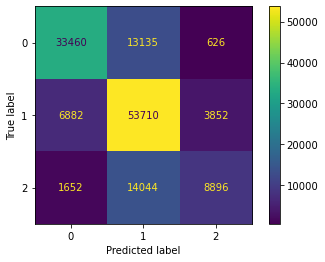

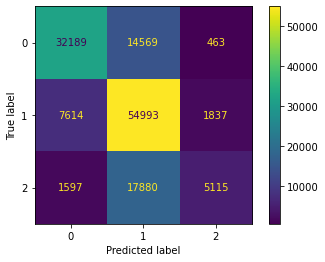

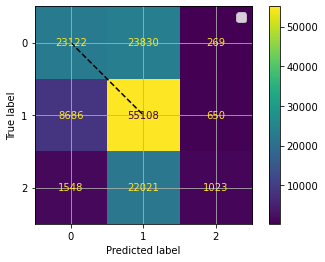

In [77]:
plt.figure(figsize = (10,8))
apply_model('test simple bow ', X_test_bow, y_test_group, lr_model_bow, print_stats = True),
apply_model('test with tf-idf', X_test_tf_idf, y_test_group, lr_model_tf_idf, print_stats = True)
apply_model('test word vectors  ', X_test_wv, y_test_group, lr_model_wv, print_stats = True),


plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.grid()

**Using embedding only for short texts.**

In [78]:
small_text_train = [text for text, y in zip(texts_train, y_train_group) if len(text.split()) < 37]
y_train_small = [y for text, y in zip(texts_train, y_train_group) if len(text.split()) < 37]

In [79]:
small_text_test = [text for text, y in zip(texts_test, y_test_group) if len(text.split()) < 37]
y_test_small = [y for text, y in zip(texts_test, y_test_group) if len(text.split()) < 37]

In [80]:
X_train_small_wv = np.stack([vectorize_sum(preprocess(text)) for text in small_text_train])
X_test_small_wv = np.stack([vectorize_sum(preprocess(text)) for text in small_text_test])

/Applications/anaconda3/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """
/Applications/anaconda3/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Applications/anaconda3/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [81]:
X_train_small_wv = np.where(np.isnan(X_train_small_wv), 0, X_train_small_wv)
X_test_small_wv = np.where(np.isnan(X_test_small_wv), 0, X_test_small_wv)

In [82]:
lr_model_small_wv = LogisticRegression(C = 0.1, max_iter = 1e4).fit(X_train_small_wv, y_train_small)

In [83]:
vectorizer_ = CountVectorizer() # TODO
X_train_small_bow = vectorizer_.fit_transform(small_text_train)
X_test_small_bow = vectorizer_.transform(small_text_test)

In [84]:
lr_model_small_bow = LogisticRegression(C = 0.1, max_iter = 1e4).fit(X_train_small_bow, y_train_small)

train small results:
Model accuracy: 0.522


No handles with labels found to put in legend.


test small results:
Model accuracy: 0.526
test  results:
Model accuracy: 0.606


<Figure size 720x576 with 0 Axes>

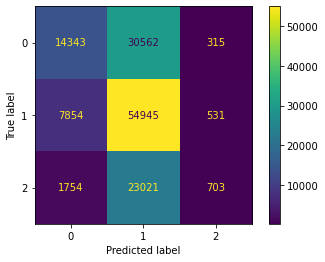

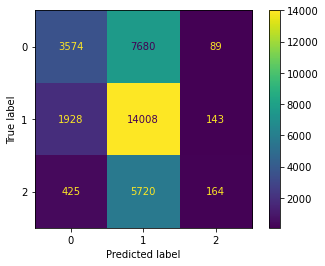

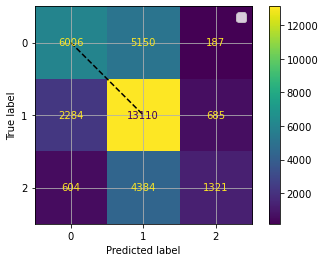

In [85]:
plt.figure(figsize = (10,8))
apply_model('train small', X_train_small_wv, y_train_small, lr_model_small_wv, print_stats = True),
apply_model('test small', X_test_small_wv, y_test_small, lr_model_small_wv, print_stats = True)
apply_model('test ', X_test_small_bow, y_test_small, lr_model_small_bow, print_stats = True)

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.grid()

Still not work. it happens)

## SVM

Could we use SVM here? Yeah, why not. Let's try. 

In [59]:
from sklearn import svm

svm_model = svm.LinearSVC(C=1.0, max_iter = 1e3)

In [60]:
svm_model.fit(X_train_bow2, y_train_group)

/Applications/anaconda3/anaconda3/lib/python3.6/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(max_iter=1000.0)

train results:
Model accuracy: 0.861
test  results:
Model accuracy: 0.691


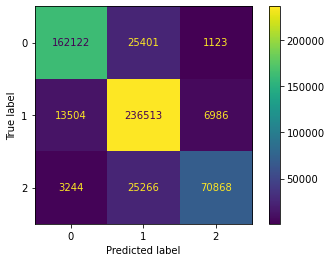

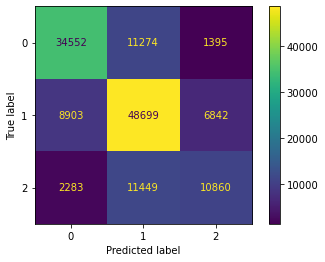

In [63]:
apply_model('train', X_train_bow2, y_train_group, svm_model)
apply_model('test ', X_test_bow2, y_test_group, svm_model)

Okay, but may be here tf_idf features may help. 

train results:
Model accuracy: 0.811
test  results:
Model accuracy: 0.715


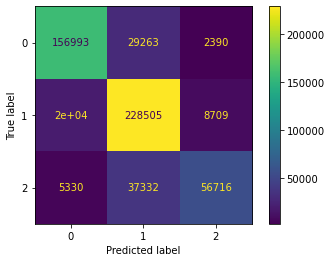

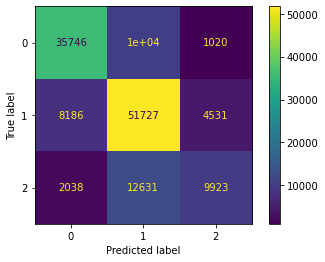

In [65]:
from sklearn import svm

svm_model_tf_idf = svm.LinearSVC(C=1.0, max_iter = 1e3)
svm_model_tf_idf.fit(X_train_tf_idf, y_train_group)

apply_model('train', X_train_tf_idf, y_train_group, svm_model_tf_idf),
apply_model('test ', X_test_tf_idf, y_test_group, svm_model_tf_idf)

Yes, it works! And by the way it is best accuracy score. 

**Findings**

So, in this work we try different ideas for solving text classification problem. 
Some thoughts after all these experiments:

1) tf-idf features might work better than just simple BOW.

2) Using bigrams and ngrams might help to impove quality but this will require more extra space.  

2) Often in such tasks SVM model works better than Naive Bayes or Logistic Regression. There is an article about it
(https://www.comp.nus.edu.sg/~leews/publications/p31189-zhang.pdf)


3) It also should be mentioned that we may tune tokenizer and preprocessor. 

**Сan be improved**

1) For sure we may tume hyperparameters like C in order to archive higher score or increase number of iteration.

2) We may also try to use scaler. Since our feature matrix is spare we can't use MinMaxScaler or StandardScaler but we may use MaxAbsScaler instead.

In [66]:
from sklearn.preprocessing import MaxAbsScaler
scaler = MaxAbsScaler()
X_train_scale = scaler.fit_transform(X_train_bow2)
X_test_scale = scaler.transform(X_test_bow2)

In [67]:
svm_model_scale = svm.LinearSVC(C=1.0, max_iter = 1e3).fit(X_train_scale, y_train_group)

train results:
Model accuracy: 0.842
test  results:
Model accuracy: 0.687


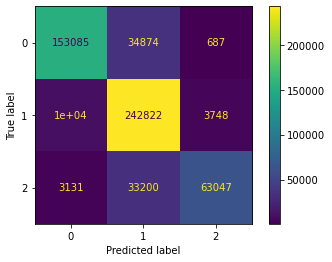

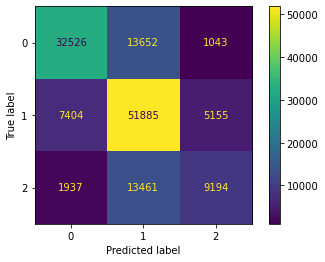

In [68]:
apply_model('train', X_train_scale, y_train_group, svm_model_scale),
apply_model('test ', X_test_scale, y_test_group, svm_model_scale)

train results:
Model accuracy: 0.865
test  results:
Model accuracy: 0.695


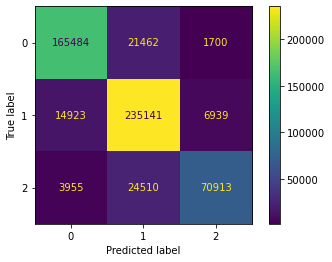

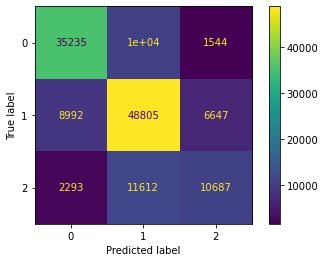

In [69]:
X_train_scale = scaler.fit_transform(X_train_tf_idf)
X_test_scale = scaler.transform(X_test_tf_idf)


svm_model_final = svm.LinearSVC(C=1.0, max_iter = 1e3)
svm_model_final.fit(X_train_scale, y_train_group)


apply_model('train', X_train_scale, y_train_group, svm_model_final),
apply_model('test ', X_test_scale, y_test_group, svm_model_final)